Deep Learning：

Epoch [1/100], Train Loss: 0.7374, Train Accuracy: 0.4902, Val Loss: 0.7493, Val Accuracy: 0.4610
Epoch [2/100], Train Loss: 0.7231, Train Accuracy: 0.5081, Val Loss: 0.7434, Val Accuracy: 0.4740
Epoch [3/100], Train Loss: 0.7084, Train Accuracy: 0.5391, Val Loss: 0.7116, Val Accuracy: 0.5065
Epoch [4/100], Train Loss: 0.6931, Train Accuracy: 0.5635, Val Loss: 0.7084, Val Accuracy: 0.5519
Epoch [5/100], Train Loss: 0.6790, Train Accuracy: 0.5879, Val Loss: 0.6873, Val Accuracy: 0.5779
Epoch [6/100], Train Loss: 0.6644, Train Accuracy: 0.5977, Val Loss: 0.6826, Val Accuracy: 0.5844
Epoch [7/100], Train Loss: 0.6566, Train Accuracy: 0.6156, Val Loss: 0.6692, Val Accuracy: 0.5909
Epoch [8/100], Train Loss: 0.6482, Train Accuracy: 0.6368, Val Loss: 0.6605, Val Accuracy: 0.6039
Epoch [9/100], Train Loss: 0.6378, Train Accuracy: 0.6433, Val Loss: 0.6426, Val Accuracy: 0.6104
Epoch [10/100], Train Loss: 0.6262, Train Accuracy: 0.6580, Val Loss: 0.6466, Val Accuracy: 0.6104
Epoch [11/100], Tra

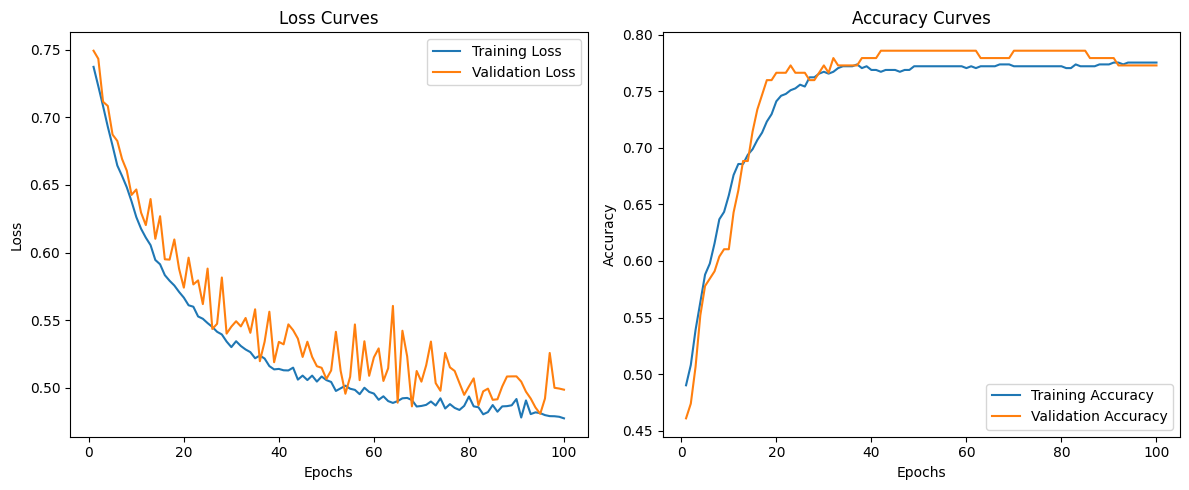

In [5]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Define the custom dataset class
class DiabetesDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.target = self.data['Outcome'].values
        self.features = self.data.drop('Outcome', axis=1).values
        self.scaler = StandardScaler()
        self.features = self.scaler.fit_transform(self.features)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.target[idx], dtype=torch.float32)
        return x, y

# Define the single-layer perceptron model
class Perceptron(nn.Module):
    def __init__(self, input_size):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc(x)
        out = self.sigmoid(out)
        return out

# Hyperparameters
batch_size = 64
learning_rate = 0.01
num_epochs = 100
split_ratio = 0.8  # 80% for training, 20% for validation

# Dataset and Dataloader setup
dataset = DiabetesDataset('diabetes.csv')
train_size = int(split_ratio * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Model, Loss, and Optimizer
model = Perceptron(input_size=len(dataset.features[0]))
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Lists for loss and accuracy
training_loss = []
validation_loss = []
training_accuracy = []
validation_accuracy = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for inputs, labels in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_correct += ((outputs > 0.5).float() == labels.unsqueeze(1)).sum().item()

    train_accuracy = train_correct / train_size
    train_loss /= len(train_loader)
    training_loss.append(train_loss)
    training_accuracy.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            val_loss += loss.item()
            val_correct += ((outputs > 0.5).float() == labels.unsqueeze(1)).sum().item()

    val_accuracy = val_correct / val_size
    val_loss /= len(val_loader)
    validation_loss.append(val_loss)
    validation_accuracy.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), training_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), training_accuracy, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()
